# Projeto Integrado Inovação - Ciência de Dados

Sua tarefa é realizar uma análise exploratória e elaborar um relatório que contenha insights baseados nos seguintes objetivos:

* Identificar as principais causas e condições associadas a acidentes graves e fatais.
* Analisar a relação entre condições meteorológicas e frequência/tipo de acidente.
* Destacar padrões relacionados ao número de veículos envolvidos e a gravidade dos acidentes.
* Propor recomendações para campanhas educativas com base nos padrões encontrados.



Desafios

1. Análise Descritiva dos Dados:  
    * Calcule a frequência de cada tipo de acidente (ex.: colisão lateral, colisão traseira) e identifique os mais comuns. OK
    * Determine a proporção de acidentes fatais, feridos e sem vítimas. OK

2. Identificação de Padrões:  
    * Analise se há relação entre as condições meteorológicas (ex.: chuva, céu claro) e a gravidade dos acidentes. OK
    * Explore como fatores como horário do acidente e o tipo de pista (simples ou dupla) influenciam os resultados. 

3. Análise de Texto das Causas de Acidentes:  
    * Agrupe causas semelhantes utilizando técnicas de análise textual.
    * Identifique as principais causas que contribuem para acidentes fatais e sugira intervenções específicas.

4. Recomendações:  
    * Proponha ações de conscientização e prevenção com base nos insights encontrados,
    * destacando os fatores mais críticos que podem ser abordados em campanhas públicas.

5. Considerações sobre Segurança de Dados:  
    * Discuta como proteger os dados sensíveis fornecidos, como localização dos acidentes (latitude/longitude)   
    e outras informações que podem ser consideradas identificáveis.


In [ ]:
# Importação de Bibliotecas

import pandas as pd
import numpy as np
import seaborn as sns
import dataframe_image as dfi

import re
import warnings
import nltk
import spacy
import matplotlib

from fuzzywuzzy import process
from collections import Counter

from matplotlib import pyplot as plt, gridspec
from matplotlib.font_manager import FontProperties

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import RSLPStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("rslp")
nltk.download('wordnet')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\syafo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\syafo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\syafo\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\syafo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [96]:
# Importação do Banco de Dados

df_datatran = pd.read_csv('datatran2024.csv', encoding='latin1', sep=';')

C:\Users\syafo\AppData\Local\Temp\ipykernel_5312\2915414220.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_datatran = pd.read_csv('datatran2024.csv', encoding='latin1', sep=';')


In [97]:
#Função para retornar tabelas de ocorrência, tipo e valores nulos
def dimensao_na(df):

    unique_values = df.apply(lambda x: x.nunique())
    na_values = df.isnull().sum()

    nome_df = pd.DataFrame({
        'Quantidade de Valores' : unique_values,
        'Tipo de Coluna' : df.dtypes,
        'Quantidade de Nulos' : na_values
    }).reset_index()

    # print(df.info())
    return nome_df

dimensao_na(df_datatran)

,index,Quantidade de Valores,Tipo de Coluna,Quantidade de Nulos
0,id,60365,object,0
1,data_inversa,305,object,0
2,dia_semana,7,object,0
3,horario,1400,object,0
4,uf,27,object,0
5,br,113,int64,0
6,km,7341,object,0
7,municipio,1809,object,0
8,causa_acidente,69,object,0
9,tipo_acidente,17,object,0


---

#### Pré-processamento e Engenharia de Atributos

In [ ]:
# Separando apenas as colunas pertinentes ao projeto

# colunas originais do DF
#['id', 'data_inversa', 'dia_semana', 'horario', 'uf', 'br', 'km', 'municipio', 'causa_acidente', 'tipo_acidente','classificacao_acidente',
#  'fase_dia', 'sentido_via', 'condicao_metereologica', 'tipo_pista', 'tracado_via', 'uso_solo', 'pessoas', 'mortos', 'feridos_leves',
#  'feridos_graves', 'ilesos', 'ignorados', 'feridos', 'veiculos', 'latitude', 'longitude', 'regional', 'delegacia', 'uop'],
#
#
df_datatran.rename(columns={'condicao_metereologica' : 'condicao_meteorologica'}, inplace=True)

df_datatran = df_datatran[['id', 'data_inversa', 'dia_semana', 'horario',
       'causa_acidente', 'tipo_acidente',
       'classificacao_acidente', 'fase_dia', 'sentido_via',
       'condicao_meteorologica', 'tipo_pista', 'tracado_via',
       'pessoas', 'mortos', 'feridos_leves', 'feridos_graves', 'ilesos',
       'feridos', 'veiculos']]


# Excluindo valores nulos:
df_datatran = df_datatran.dropna()

#Datetime

df_datatran['data_inversa'] = pd.to_datetime(df_datatran['data_inversa'], format='%d/%m/%Y')
df_datatran['horario'] = pd.to_datetime(df_datatran['horario'], format='%H:%M:%S', errors='coerce')

# Criar coluna hora com o numero inteiro
df_datatran['hora'] = df_datatran['horario'].dt.hour


# Renomeando atributos de 'classificacao_acidente'

rename_classificacao_acidente = {
    'Com Vítimas Feridas' : 'Vítimas Feridas',
    'Com Vítimas Fatais' : 'Vítimas Fatais',
    'Vítimas' : 'Sem Vítimas',
}

df_datatran['classificacao_acidente'] = df_datatran['classificacao_acidente'].replace(rename_classificacao_acidente)

# criando coluna de coeficiente de gravidade 
# feridos leves = 1
# feridos graves = 3
# mortos = 5
df_datatran['gravidade_coeficiente'] = (
    df_datatran['veiculos'] * 0.1 +
    df_datatran['feridos_leves'] * 1.25 +
    df_datatran['feridos_graves'] * 2.5 +
    df_datatran['mortos'] * 5 
)

# Definindo as faixas de gravidade
def categorizar_gravidade(gravidade):
    if gravidade < 0.18:
        return 'muito baixo'
    elif 0.18 <= gravidade < 1.88:
        return 'baixo'
    elif 1.88 <= gravidade < 5.28:
        return 'médio'
    elif 5.28 <= gravidade < 10:
        return 'alto'
    else:
        return 'muito alto'

# Aplicando a função para criar a nova coluna 'gravidade_nivel'
df_datatran['gravidade_nivel'] = df_datatran['gravidade_coeficiente'].apply(categorizar_gravidade)


---

### Análise Descritiva dos Dados

#### Relatório:

* Identificar as principais causas e condições associadas a acidentes graves e fatais. OK
* Analisar a relação entre condições meteorológicas e frequência/tipo de acidente. OK
* Destacar padrões relacionados ao número de veículos envolvidos e a gravidade dos acidentes. OK
* Propor recomendações para campanhas educativas com base nos padrões encontrados.

In [126]:
# ESTATÍSTICA DESCRITIVA - VARIÁVEL NÃO NUMÉRICA
# Função para retornar perfil estatístico inicial
def estatistica_nao_numerica(df):

    df = df.drop(columns='id', errors='coerce')

    character = df.select_dtypes(include=('object')) 

    # criar Dataframe
    stats = pd.DataFrame()

    # número de categorias únicas
    stats['N° de Categorias Únicas'] = character.nunique()

    #moda
    stats['Moda'] = character.mode().iloc[0]

    #frequência da moda
    stats['Frequência da Moda'] = character.apply(lambda x: x.value_counts().iloc[0])

    #proporção da moda
    stats['Proporção da Moda'] = (stats['Frequência da Moda'] / len(character)).apply(lambda x: f'{x:.2%}')

    #menor frequência
    stats['Categoria de menor frequência'] = character.apply(lambda x: x.value_counts().idxmin())

    #numero da menor frequência
    stats['Menor frequência'] = character.apply(lambda x: x.value_counts().min())

    #proporção da menor frequência
    stats['Proporção da menor frequência'] = (stats['Menor frequência'] / len(character)).apply(lambda x: f'{x:.2%}')

    return stats
estatistica_nao_numerica(df_datatran)

,N° de Categorias Únicas,Moda,Frequência da Moda,Proporção da Moda,Categoria de menor frequência,Menor frequência,Proporção da menor frequência
dia_semana,7,domingo,9687,16.05%,terça-feira,7656,12.68%
causa_acidente,69,Reação tardia ou ineficiente do condutor,9000,14.91%,Sinalização encoberta,2,0.00%
tipo_acidente,17,Colisão traseira,11638,19.28%,Sinistro pessoal de trânsito,11,0.02%
classificacao_acidente,3,Vítimas Feridas,46299,76.70%,Vítimas Fatais,4297,7.12%
fase_dia,4,Pleno dia,32893,54.49%,Amanhecer,2891,4.79%
sentido_via,3,Crescente,32332,53.56%,Não Informado,150,0.25%
condicao_meteorologica,10,Céu Claro,39332,65.16%,Neve,1,0.00%
tipo_pista,3,Simples,29121,48.24%,Múltipla,5915,9.80%
tracado_via,592,Reta,33622,55.70%,Reta;Declive;Interseção de Vias;Rotatória;Retorno Regulamentado,1,0.00%
gravidade_nivel,5,baixo,30539,50.59%,muito alto,1085,1.80%


In [127]:
# ESTATÍSTICA DESCRITIVA - VARIÁVEL NUMÉRICA
def estatistica_numerica(df):
    df = df.drop(columns=(['id']), errors='coerce')

    numericas = df.select_dtypes(include=['int64', 'float64'])

    stats = pd.DataFrame()

    # Estatísticas básicas
    stats['Total de Valores'] = numericas.count()
    stats['Média'] = numericas.mean()
    stats['Mediana'] = numericas.median()
    stats['Desvio Padrão'] = numericas.std()
    stats['Valor Mínimo'] = numericas.min()
    stats['Valor Máximo'] = numericas.max()

    # Proporção do valor máximo sobre a soma total (quando fizer sentido)
    stats['Proporção do Máximo'] = (numericas.max() / numericas.sum()).apply(lambda x: f'{x:.2%}')

    # Percentual de zeros (caso relevante, como em colunas de contagem)
    stats['% de Zeros'] = (numericas.apply(lambda x: (x == 0).sum()) / len(numericas)).apply(lambda x: f'{x:.2%}')

    return stats.round(2)

estatistica_numerica(df_datatran)

,Total de Valores,Média,Mediana,Desvio Padrão,Valor Mínimo,Valor Máximo,Proporção do Máximo,% de Zeros
pessoas,60364,2.59,2.00,2.15,1.0,61.0,0.04%,0.00%
mortos,60364,0.08,0.00,0.34,0.0,23.0,0.46%,92.88%
feridos_leves,60364,0.87,1.00,1.09,0.0,43.0,0.08%,37.15%
feridos_graves,60364,0.28,0.00,0.63,0.0,30.0,0.18%,77.39%
ilesos,60364,1.04,1.00,1.69,0.0,60.0,0.10%,37.97%
feridos,60364,1.15,1.00,1.20,0.0,45.0,0.06%,20.72%
veiculos,60364,2.00,2.00,1.09,1.0,26.0,0.02%,0.00%
gravidade_coeficiente,60364,2.40,1.45,2.68,0.1,137.7,0.10%,0.00%


In [101]:
# TABELA 2
# Top 15 causas tipos de acidentes

def top_15(df, variavel):

    if variavel == 'causa':
        top_15_causas = df['causa_acidente'].value_counts().head(15).reset_index(name='Quantidade')
        return top_15_causas
    elif variavel == 'tipo':
        top_15_tipos = df['tipo_acidente'].value_counts().head(15).reset_index(name='Quantidade')
        return top_15_tipos

top_15(df_datatran, 'tipo')

,tipo_acidente,Quantidade
0,Colisão traseira,11638
1,Saída de leito carroçável,8791
2,Colisão transversal,7761
3,Colisão lateral mesmo sentido,6546
4,Tombamento,5311
5,Colisão com objeto,4140
6,Colisão frontal,3951
7,Queda de ocupante de veículo,2807
8,Atropelamento de Pedestre,2661
9,Colisão lateral sentido oposto,1662


In [102]:
df_datatran_corr = df_datatran.select_dtypes(include=['number'])
df_datatran_corr.corr()

,pessoas,mortos,feridos_leves,feridos_graves,ilesos,feridos,veiculos,gravidade_coeficiente,hora
pessoas,1.000000,0.175422,0.450252,0.252102,0.778076,0.538121,0.415452,0.505084,0.006997
mortos,0.175422,1.000000,-0.073705,0.104653,-0.009954,-0.011914,0.133312,0.671219,0.007850
feridos_leves,0.450252,-0.073705,1.000000,-0.093014,0.008375,0.854309,0.023113,0.405503,-0.004075
feridos_graves,0.252102,0.104653,-0.093014,1.000000,-0.014446,0.438049,0.077185,0.608726,0.024735
ilesos,0.778076,-0.009954,0.008375,-0.014446,1.000000,0.000021,0.295418,0.001417,0.011289
feridos,0.538121,-0.011914,0.854309,0.438049,0.000021,1.000000,0.061161,0.683887,0.009234
veiculos,0.415452,0.133312,0.023113,0.077185,0.295418,0.061161,1.000000,0.183158,0.020021
gravidade_coeficiente,0.505084,0.671219,0.405503,0.608726,0.001417,0.683887,0.183158,1.000000,0.018273
hora,0.006997,0.007850,-0.004075,0.024735,0.011289,0.009234,0.020021,0.018273,1.000000


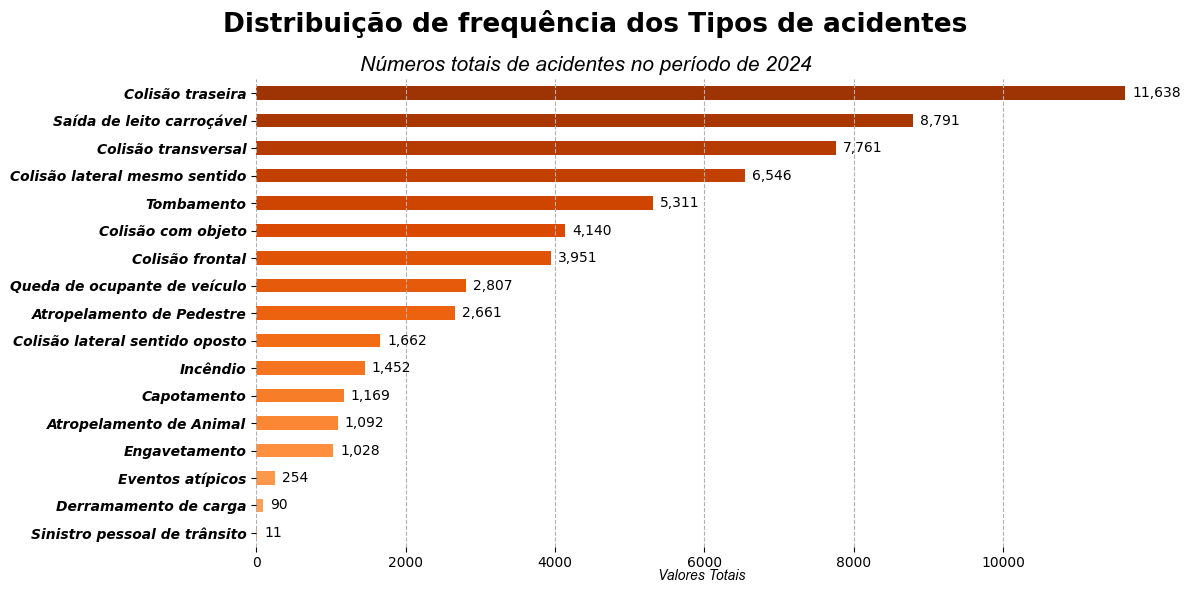

In [103]:
# Frequência dos tipos de acidente (em ordem crescente)
df_datatran_frequencia_tipo_acidente = df_datatran['tipo_acidente'].value_counts(ascending=True)

# Propriedades da fonte para o título secundário
fontprops = {
    'fontsize': 15,
    'fontweight': 'medium',
    'fontstyle': 'oblique',
    'fontfamily': 'Arial',
    'verticalalignment': 'center',
    'horizontalalignment': 'center',
    'stretch': 'expanded'
}

cores = plt.cm.Oranges(np.linspace(0.4, 0.9, len(df_datatran_frequencia_tipo_acidente)))

# Criando a figura e eixo
fig, ax = plt.subplots(figsize=(12, 6))

# Plot do gráfico de barras horizontais
df_datatran_frequencia_tipo_acidente.plot(kind='barh', color=cores, ax=ax)

# Anotando os valores nas barras
for patch in ax.patches:
    ax.annotate(f"{patch.get_width():,.0f}",
                (patch.get_width(), patch.get_y() + patch.get_height() / 2),
                ha='left', va='center',
                xytext=(5, 0), textcoords='offset points',
                fontsize=10)

# Títulos
plt.suptitle('Distribuição de frequência dos Tipos de acidentes', fontsize=19, fontweight='bold')
ax.set_title('Números totais de acidentes no período de 2024', fontdict=fontprops, x=0.37, pad=10)

# Limpeza visual
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.margins(0.025)
ax.set_ylabel('')
plt.yticks(fontweight='semibold', fontstyle='italic')
plt.xlabel('Valores Totais', fontdict=fontprops, fontsize=10)
plt.grid(axis='x', linestyle='--')
# Mostrar gráfico
plt.tight_layout()
plt.show()


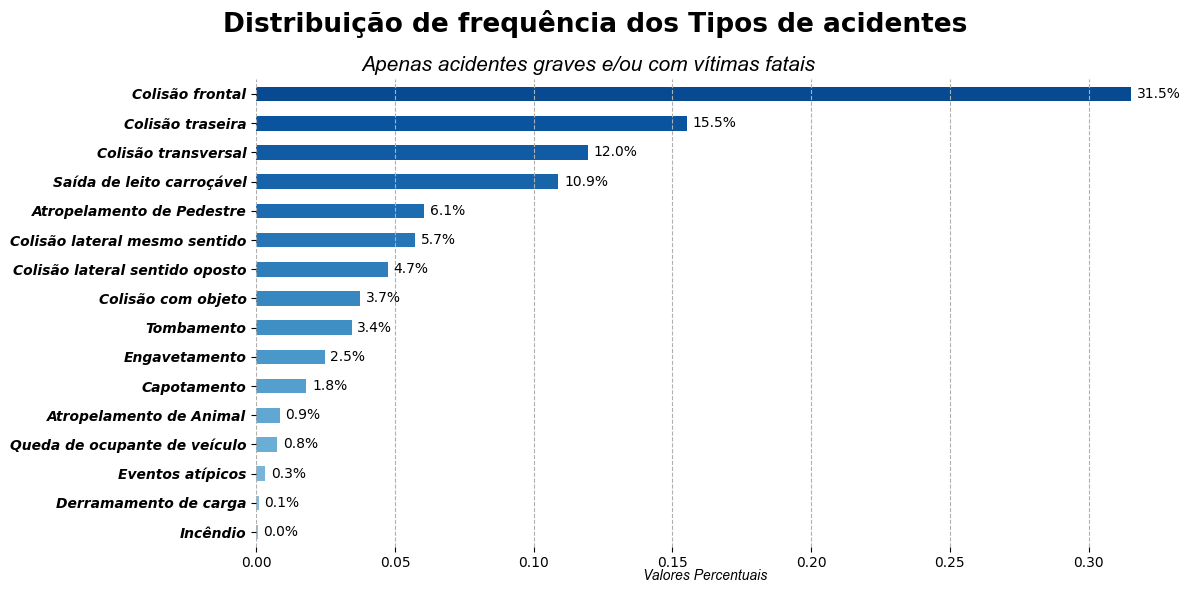

In [104]:
# Frequência dos tipos de acidente (em ordem crescente)


acidentes_mortes = df_datatran[(df_datatran['gravidade_nivel'] == 'alto') |
                               (df_datatran['gravidade_nivel'] == 'muito alto')]
acidentes = acidentes_mortes['tipo_acidente'].value_counts(ascending=True)

acidentes_pct = acidentes / acidentes.sum()  # proporção

# Propriedades da fonte para o título secundário
fontprops = {
    'fontsize': 15,
    'fontweight': 'medium',
    'fontstyle': 'oblique',
    'fontfamily': 'Arial',
    'verticalalignment': 'center',
    'horizontalalignment': 'center',
    'stretch': 'expanded'
}

cores = plt.cm.Blues(np.linspace(0.4, 0.9, len(acidentes)))

# Criando a figura e eixo
fig, ax = plt.subplots(figsize=(12, 6))

# Plot do gráfico de barras horizontais
acidentes_pct.plot(kind='barh', color=cores, ax=ax)

# Anotando os valores nas barras
for i, (valor, nome) in enumerate(zip(acidentes_pct.values, acidentes_pct.index)):
    plt.text(valor + 0.002, i, f'{valor:.1%}', va='center', fontsize=10)


# Títulos
plt.suptitle('Distribuição de frequência dos Tipos de acidentes', fontsize=19, fontweight='bold')
ax.set_title('Apenas acidentes graves e/ou com vítimas fatais', fontdict=fontprops, x=0.37, pad=10)

# Limpeza visual
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.margins(0.025)
ax.set_ylabel('')
plt.yticks(fontweight='semibold', fontstyle='italic')
plt.xlabel('Valores Percentuais', fontdict=fontprops, fontsize=10)
plt.grid(axis='x', linestyle='--')

# Mostrar gráfico
plt.tight_layout()
plt.show()


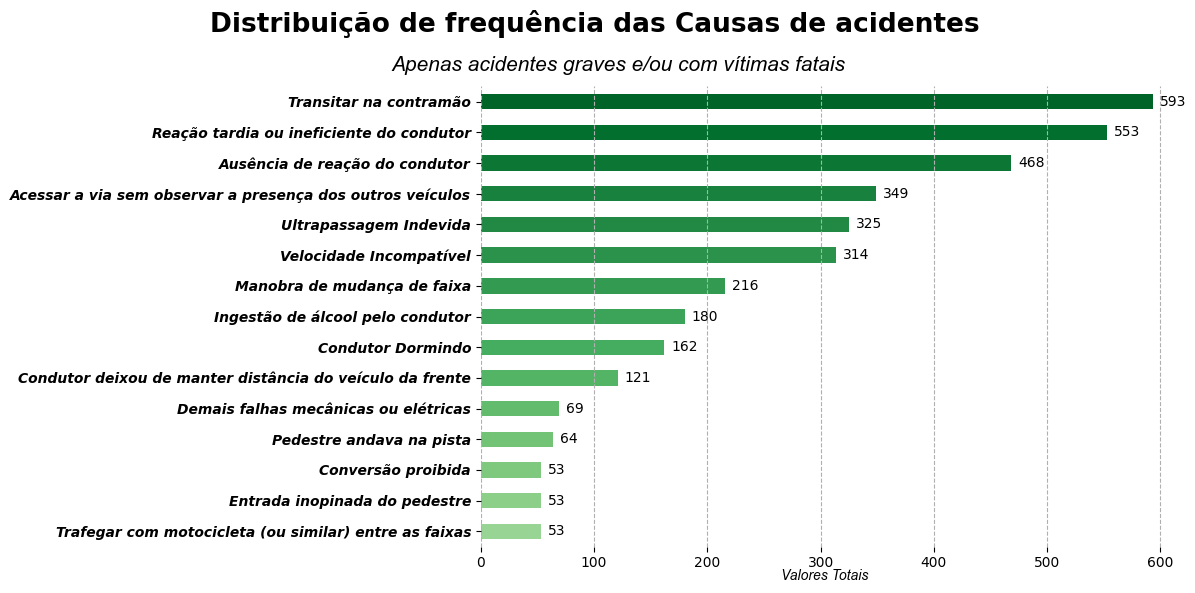

In [105]:
acidentes_mortes = df_datatran[
    (df_datatran['gravidade_nivel'] == 'alto') |
    (df_datatran['gravidade_nivel'] == 'muito alto')
]

# Contagem das 15 causas menos frequentes (ordem crescente)
top_15_causas = acidentes_mortes['causa_acidente'].value_counts(ascending=False).head(15)
# Propriedades da fonte para o título secundário
fontprops = {
    'fontsize': 15,
    'fontweight': 'medium',
    'fontstyle': 'oblique',
    'fontfamily': 'Arial',
    'verticalalignment': 'center',
    'horizontalalignment': 'center',
    'stretch': 'expanded'
}

cores = plt.cm.Greens(np.linspace(0.4, 0.9, len(top_15_causas)))

top_15_causas = top_15_causas.iloc[::-1]
# Criando a figura e eixo
fig, ax = plt.subplots(figsize=(12, 6))

# Plot do gráfico de barras horizontais
top_15_causas.plot(kind='barh', color=cores, ax=ax)

# Anotando os valores nas barras
for patch in ax.patches:
    ax.annotate(f"{patch.get_width():,.0f}",
                (patch.get_width(), patch.get_y() + patch.get_height() / 2),
                ha='left', va='center',
                xytext=(5, 0), textcoords='offset points',
                fontsize=10)

# Títulos
plt.suptitle('Distribuição de frequência das Causas de acidentes', fontsize=19, fontweight='bold')
ax.set_title('Apenas acidentes graves e/ou com vítimas fatais', fontdict=fontprops, x=0.20, pad=15)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.margins(0.025)
ax.set_ylabel('')
plt.yticks(fontweight='semibold', fontstyle='italic')
plt.xlabel('Valores Totais', fontdict=fontprops, fontsize=10)
plt.grid(axis='x', linestyle='--')

plt.tight_layout()
plt.show()


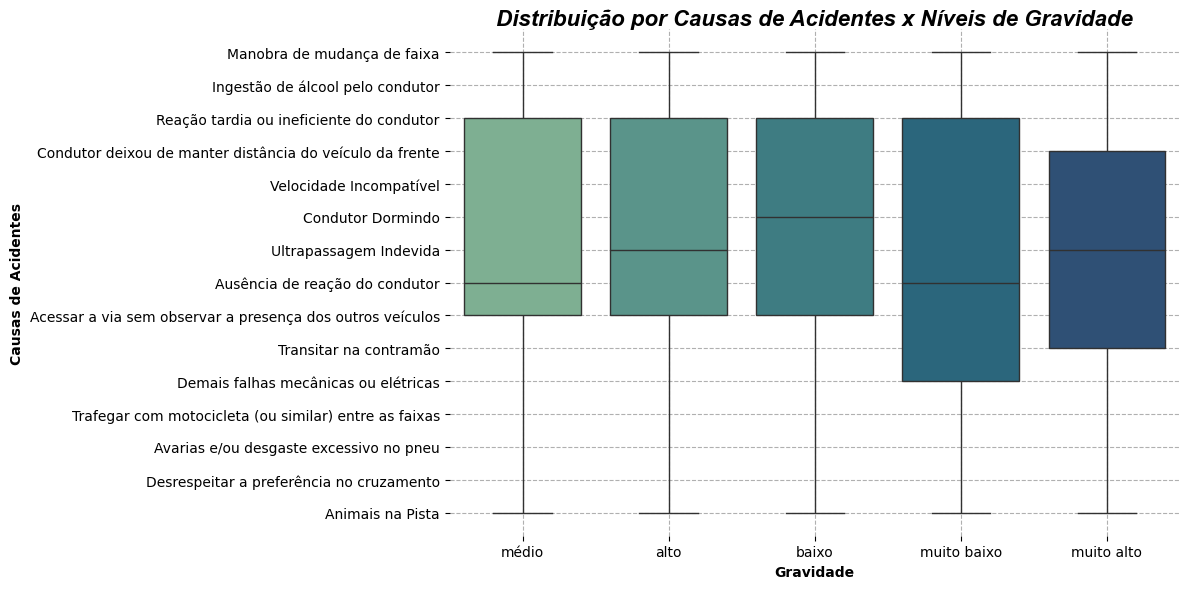

In [106]:
# GRÁFICO BOXPLOT - Causas X Gravidade

outlier_p = dict( #formatação do ponto outlier
    marker='o',
    markersize=3,
    linestyle=None,
    markerfacecolor='red',
    alpha=0.5
)

fontprops = { #formatação da fonte
    'fontsize': 15,
    'fontweight': 'medium',
    'fontstyle': 'oblique',
    'fontfamily': 'Arial',
    'verticalalignment': 'center',
    'horizontalalignment': 'center',
    'stretch': 'expanded'
}

#criação do top 15 
top_15_causas = df_datatran['causa_acidente'].value_counts().head(15).index
df_datatran_top_15_causas = df_datatran[df_datatran['causa_acidente'].isin(top_15_causas)]

# Gráfico
plt.figure(figsize=(12, 6))
sns.boxplot(x='gravidade_nivel', y='causa_acidente', data=df_datatran_top_15_causas, flierprops=outlier_p, palette='crest') #boxplot
plt.title('Distribuição por Causas de Acidentes x Níveis de Gravidade', fontdict=fontprops, fontsize=16, fontweight='bold') #titulo
plt.ylabel('Causas de Acidentes', fontweight='semibold')
plt.xlabel('Gravidade', fontweight='semibold')
plt.grid(linestyle='--')
plt.box(None)

plt.tight_layout()
plt.show()

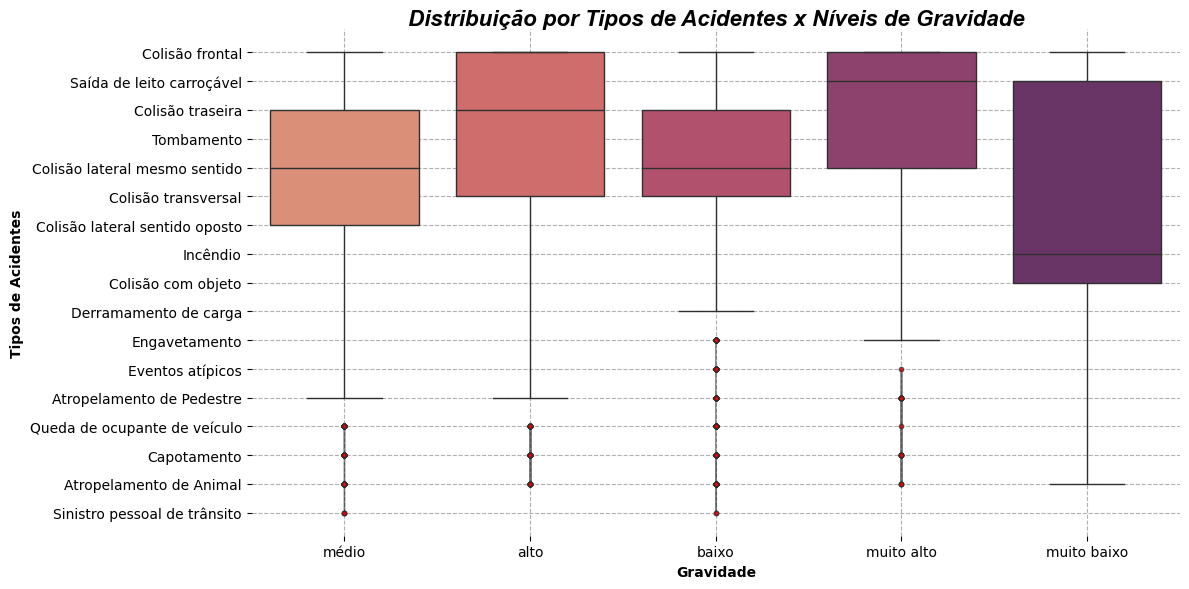

In [107]:
# GRÁFICO BOXPLOT - Tipos X Gravidade

outlier_p = dict( #formatação do ponto outlier
    marker='o',
    markersize=3,
    linestyle=None,
    markerfacecolor='red',
    alpha=0.5
)

fontprops = { #formatação da fonte
    'fontsize': 15,
    'fontweight': 'medium',
    'fontstyle': 'oblique',
    'fontfamily': 'Arial',
    'verticalalignment': 'center',
    'horizontalalignment': 'center',
    'stretch': 'expanded'
}

# Gráfico
plt.figure(figsize=(12, 6))
sns.boxplot(x='gravidade_nivel', y='tipo_acidente', data=df_datatran, flierprops=outlier_p, palette='flare') #boxplot
plt.title('Distribuição por Tipos de Acidentes x Níveis de Gravidade', fontdict=fontprops, fontsize=16, fontweight='bold') #titulo
plt.ylabel('Tipos de Acidentes', fontweight='semibold')
plt.xlabel('Gravidade', fontweight='semibold')
plt.grid(linestyle='--')
plt.box(None)

plt.tight_layout()
plt.show()

In [108]:
# TABELA 3
# Relacionar as 15 principais causas de acidentes graves ou fatais com a moda 
# (valores mais recorrentes) das variáveis pertinentes para a análise de causa e gravidade

def top_15_causas_e_moda(df):

    top_15_causas = df['causa_acidente'].value_counts(ascending=False).head(15) # criar ranking top 15 de causas 
    lista_top_15 = top_15_causas.index # extrair apenas o index
    df_top_causas = df[df['causa_acidente'].isin(lista_top_15)] # criar df apenas com o ranking
    df_top_causas_graves_fatais = df_top_causas[(df_top_causas['gravidade_nivel'] == 'alto') |
                                                (df_top_causas['gravidade_nivel'] == 'muito alto')]

    coluna_analise = [ # relacionar colunas de interesse
        'tipo_acidente',
        'fase_dia',
        'horario',
        'condicao_meteorologica',
        'feridos_graves',
        'mortos',
        'gravidade_nivel',
        'gravidade_coeficiente',

    ]

    def moda(serie): #função para achar a moda das valores
        return serie.mode().iloc[0] if not serie.mode().empty else None

    df_perfil_causas = df_top_causas_graves_fatais.groupby('causa_acidente')[coluna_analise].agg(moda).reset_index().head(15) # criando df com a moda de cada coluna

    df_perfil_causas['frequencia'] = df_perfil_causas['causa_acidente'].map(top_15_causas) #criando contador de frequencia para organizar top 10
    df_perfil_causas = df_perfil_causas.sort_values(by='frequencia', ascending=False) # organizando o df por frequencia

    df_perfil_causas.reset_index(drop=True, inplace=True) 
    return df_perfil_causas

top_15_causas_e_moda(df_datatran)

,causa_acidente,tipo_acidente,fase_dia,horario,condicao_meteorologica,feridos_graves,mortos,gravidade_nivel,gravidade_coeficiente,frequencia
0,Reação tardia ou ineficiente do condutor,Colisão traseira,Pleno dia,1900-01-01 17:00:00,Céu Claro,0,0,alto,5.30,9000
1,Ausência de reação do condutor,Colisão traseira,Pleno dia,1900-01-01 05:30:00,Céu Claro,0,1,alto,5.30,8804
2,Acessar a via sem observar a presença dos outros veículos,Colisão transversal,Pleno dia,1900-01-01 19:30:00,Céu Claro,0,0,alto,5.30,5768
3,Condutor deixou de manter distância do veículo da frente,Colisão traseira,Pleno dia,1900-01-01 07:35:00,Céu Claro,0,0,alto,5.30,3731
4,Manobra de mudança de faixa,Colisão frontal,Pleno dia,1900-01-01 17:00:00,Céu Claro,0,1,alto,5.30,3491
5,Velocidade Incompatível,Saída de leito carroçável,Pleno dia,1900-01-01 16:00:00,Céu Claro,0,1,alto,5.30,3475
6,Ingestão de álcool pelo condutor,Colisão frontal,Plena Noite,1900-01-01 05:20:00,Céu Claro,0,0,alto,7.70,3171
7,Demais falhas mecânicas ou elétricas,Colisão traseira,Pleno dia,1900-01-01 19:00:00,Céu Claro,0,0,alto,5.30,2840
8,Transitar na contramão,Colisão frontal,Plena Noite,1900-01-01 19:30:00,Céu Claro,0,1,alto,5.30,2018
9,Condutor Dormindo,Colisão frontal,Pleno dia,1900-01-01 05:00:00,Céu Claro,0,1,alto,6.35,1760


<Figure size 1000x600 with 0 Axes>

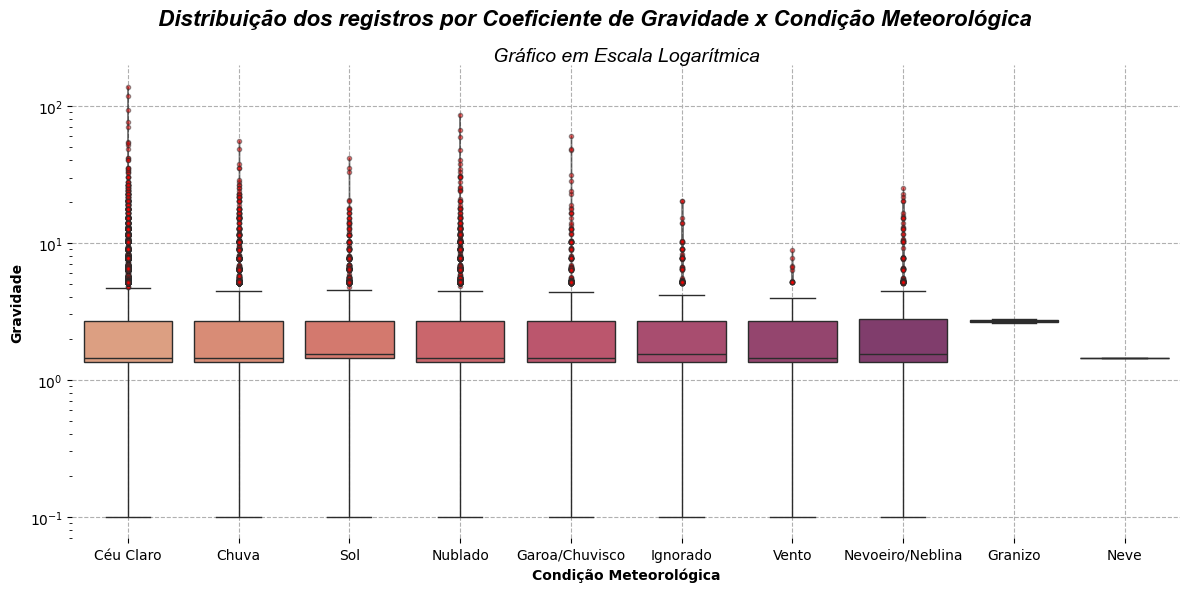

In [109]:
# GRÁFICO BOXPLOT

plt.figure(figsize=(10,6))

outlier_p = dict(
    marker='o',
    markersize=3,
    linestyle=None,
    markerfacecolor='red',
    alpha=0.5
)

fontprops = {
    'fontsize': 15,
    'fontweight': 'medium',
    'fontstyle': 'oblique',
    'fontfamily': 'Arial',
    'verticalalignment': 'center',
    'horizontalalignment': 'center',
    'stretch': 'expanded'
}

# Criando a figura e eixo
fig, ax = plt.subplots(figsize=(12, 6))

# Plot do gráfico de barras horizontais
#Gráfico1
sns.boxplot(x='condicao_meteorologica', y='gravidade_coeficiente', data=df_datatran, flierprops=outlier_p, palette='flare')
plt.suptitle('Distribuição dos registros por Coeficiente de Gravidade x Condição Meteorológica', fontdict=fontprops, fontsize=16, fontweight='bold')
plt.title('Gráfico em Escala Logarítmica', fontdict=fontprops, fontsize=14, fontweight='normal', fontstyle='italic')
plt.ylabel('Gravidade', fontweight='semibold')
plt.xlabel('Condição Meteorológica', fontweight='semibold')
plt.grid(linestyle='--')
plt.box(None)
plt.yscale('log')

plt.tight_layout()
plt.show()

In [110]:
# TABELA 5
# Distribuição proporcional das condições metereológicas das top 10 tipos de acidentes e moda

def top_10_tipos_e_moda_proporcional(df):

    top_10_tipos = df['tipo_acidente'].value_counts().head(10).index # ranking top 10 tipos
    df_top_10_tipos = df[df['tipo_acidente'].isin(top_10_tipos)]
    df_top_10_tipos['frequencia'] = df['tipo_acidente'].value_counts().head(10)

    proporcao_condicao_meteorologica = pd.crosstab( # criação da tabela cruzada
        df_top_10_tipos['tipo_acidente'],
        df_top_10_tipos['condicao_meteorologica'],
        normalize='index'
    ).round(3)

    ordem = df_top_10_tipos['tipo_acidente'].value_counts().index
    proporcao_condicao_meteorologica = proporcao_condicao_meteorologica.loc[ordem]

    return proporcao_condicao_meteorologica # retorna tabela

top_10_tipos_e_moda_proporcional(df_datatran)

condicao_meteorologica,Chuva,Céu Claro,Garoa/Chuvisco,Granizo,Ignorado,Neve,Nevoeiro/Neblina,Nublado,Sol,Vento
tipo_acidente,,,,,,,,,,
Colisão traseira,0.062,0.677,0.031,0.0,0.012,0.0,0.007,0.145,0.065,0.002
Saída de leito carroçável,0.181,0.564,0.046,0.0,0.017,0.0,0.014,0.139,0.036,0.001
Colisão transversal,0.053,0.692,0.025,0.0,0.009,0.0,0.007,0.144,0.069,0.001
Colisão lateral mesmo sentido,0.046,0.693,0.026,0.0,0.008,0.0,0.005,0.147,0.073,0.002
Tombamento,0.084,0.632,0.038,0.0,0.011,0.0,0.008,0.156,0.068,0.003
Colisão com objeto,0.154,0.580,0.053,0.0,0.012,0.0,0.015,0.145,0.039,0.002
Colisão frontal,0.117,0.637,0.037,0.0,0.014,0.0,0.017,0.138,0.040,0.001
Queda de ocupante de veículo,0.064,0.710,0.033,0.0,0.015,0.0,0.010,0.124,0.044,0.001
Atropelamento de Pedestre,0.064,0.693,0.033,0.0,0.020,0.0,0.007,0.151,0.030,0.003


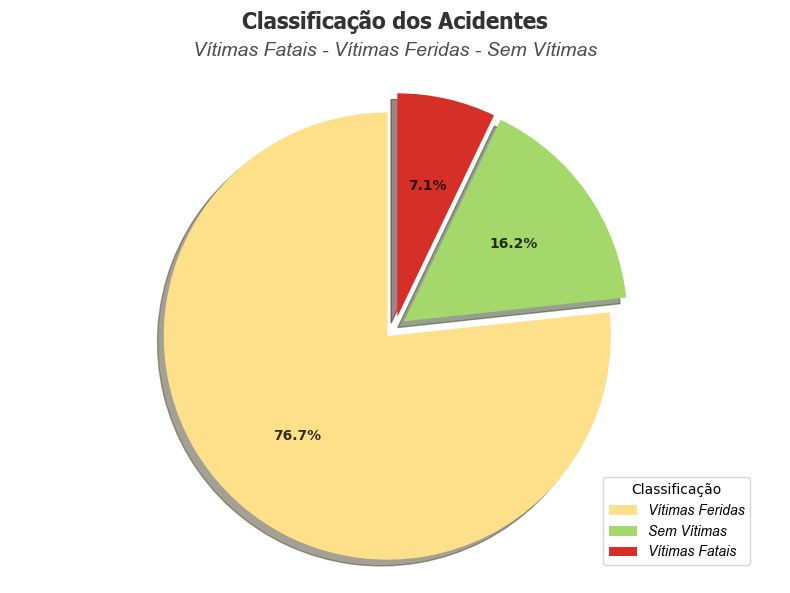

In [111]:
# GRÁFICO 3
# Gráfico de Pizza - Proporção das classificações dos acidentes

df_datatran_classificacao_acidente = df_datatran['classificacao_acidente'].value_counts(ascending=False)
# labels
labels = df_datatran_classificacao_acidente.index #atributos
values = df_datatran_classificacao_acidente.values #valores

# separar fatias
explode = [0.05] * len(labels)

# cores das fatias
cores = plt.cm.RdYlGn([0.4, 0.7, 0.1])

# cor do texto dos atributos
alpha_color = matplotlib.colors.to_rgba('black', alpha=0.8)

# criando o gráfico
plt.figure(figsize=(8,6))
plt.pie(
    values, 
    # labels=labels, 
    autopct='%1.1f%%', 
    startangle=90, 
    explode=explode,
    colors=cores,
    textprops={'color':alpha_color,
               'fontweight': 'bold'},
               shadow=True)

fontprops = {'fontweight':'normal', 'style': 'italic', 'family' : 'Arial'}
fontprops_legend = FontProperties(family='Arial', style='italic', weight='normal', size=10)

plt.suptitle('Classificação dos Acidentes',
             fontfamily='Tahoma',
             fontweight='heavy',
             fontstyle='normal',
             alpha=0.8,
             fontsize=16)
plt.title('Vítimas Fatais - Vítimas Feridas - Sem Vítimas',fontdict=fontprops, fontsize=14, pad=10, alpha=0.7)
plt.legend(labels, 
           title="Classificação", 
           loc='upper right', 
           prop=fontprops_legend,
           bbox_to_anchor=(0.97, 0.22))
plt.axis('equal')
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


In [112]:
# Gráfico causas de acidentes e contagens de vítimas

def top_10_causas_contagem_vitimas(df):
    top_10_causas = df['causa_acidente'].value_counts().head(10).index
    df_top_10 = df[df['causa_acidente'].isin(top_10_causas)] 

    top_causas_contagem_vitimas = df_top_10.groupby('classificacao_acidente')[[
        'pessoas',
        'feridos',
        'feridos_leves',
        'feridos_graves',
        'gravidade_coeficiente',
        'mortos',
        'ilesos'
    ]].sum().sort_values(by='pessoas', ascending=False).reset_index()

    return top_causas_contagem_vitimas

top_10_causas_contagem_vitimas(df_datatran)


,classificacao_acidente,pessoas,feridos,feridos_leves,feridos_graves,gravidade_coeficiente,mortos,ilesos
0,Vítimas Feridas,87157,47247,36726,10521,78876.10,0,31237
1,Sem Vítimas,17338,0,0,0,1497.10,0,13628
2,Vítimas Fatais,10047,2573,1381,1192,21959.65,3310,2583


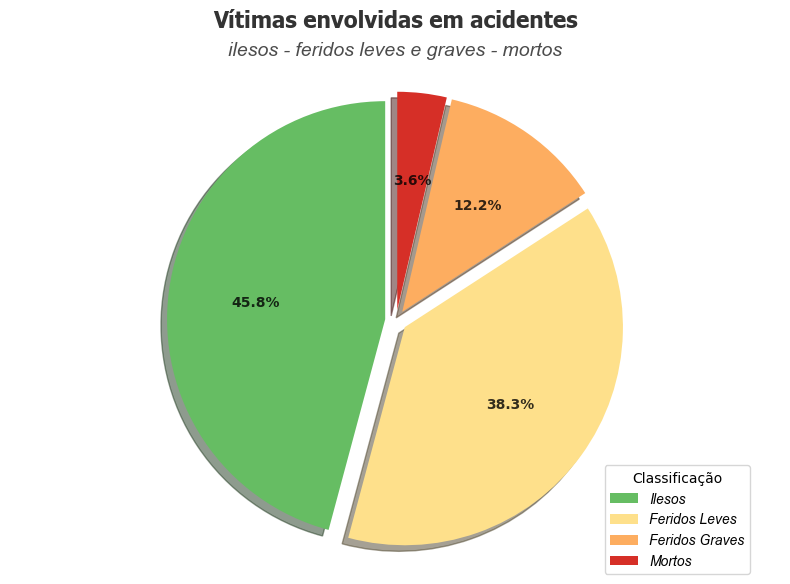

In [113]:
# GRÁFICO 3
# Gráfico de Pizza - Proporção das classificações dos acidentes

totais = {
    'Ilesos': df_datatran['ilesos'].sum(),
    'Feridos Leves': df_datatran['feridos_leves'].sum(),
    'Feridos Graves': df_datatran['feridos_graves'].sum(),
    'Mortos': df_datatran['mortos'].sum()
}

# separar fatias
explode = [0.05] * len(totais)

# cores das fatias
cores = plt.cm.RdYlGn([.8, 0.4, 0.3, 0.1])


# Cálculo da proporção
total_pessoas = sum(totais.values())
proporcoes = {k: v / total_pessoas for k, v in totais.items()}


# cor do texto dos atributos
alpha_color = matplotlib.colors.to_rgba('black', alpha=0.8)

# criando o gráfico
plt.figure(figsize=(8,6))
plt.pie(
    totais.values(), 
    #labels=totais.keys(),
    # labels=labels, 
    autopct='%1.1f%%', 
    startangle=90, 
    explode=explode,
    colors=cores,
    textprops={'color':alpha_color,
               'fontweight': 'bold'},
               shadow=True)

fontprops = {'fontweight':'normal', 'style': 'italic', 'family' : 'Arial'}
fontprops_legend = FontProperties(family='Arial', style='italic', weight='regular', size=10)

plt.suptitle('Vítimas envolvidas em acidentes',
             fontfamily='Tahoma',
             fontweight='heavy',
             fontstyle='normal',
             alpha=0.8,
             fontsize=16)
plt.title('ilesos - feridos leves e graves - mortos', fontstyle='italic', fontdict=fontprops, fontsize=14, pad=10, alpha=0.7)
plt.legend(totais, 
           title="Classificação", 
           loc='upper right', 
           prop=fontprops_legend,
           bbox_to_anchor=(0.97, 0.22))
plt.axis('equal')
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

In [114]:
def estatistica_coluna_unica(df, tab):

    dados = df[tab]

    estatisticas = {
        'Total' : dados.sum(),
        'Média': dados.mean(),
        'Mediana': dados.median(),
        'Moda': dados.mode().iloc[0] if not dados.mode().empty else np.nan,
        'Desvio Padrão': dados.std(),
        'Mínimo': dados.min(),
        'Máximo': dados.max(),
        'Range': dados.max() - dados.min(),
        '1º Quartil (25%)': dados.quantile(0.25),
        '2º Quartil (50%)': dados.quantile(0.50),
        '3º Quartil (75%)': dados.quantile(0.75),
    }
    return pd.DataFrame(estatisticas, index=['Veículos']).round(3)

estatistica_coluna_unica(df_datatran, 'veiculos')

,Total,Média,Mediana,Moda,Desvio Padrão,Mínimo,Máximo,Range,1º Quartil (25%),2º Quartil (50%),3º Quartil (75%)
Veículos,120432,1.995,2.0,2,1.092,1,26,25,1.0,2.0,2.0


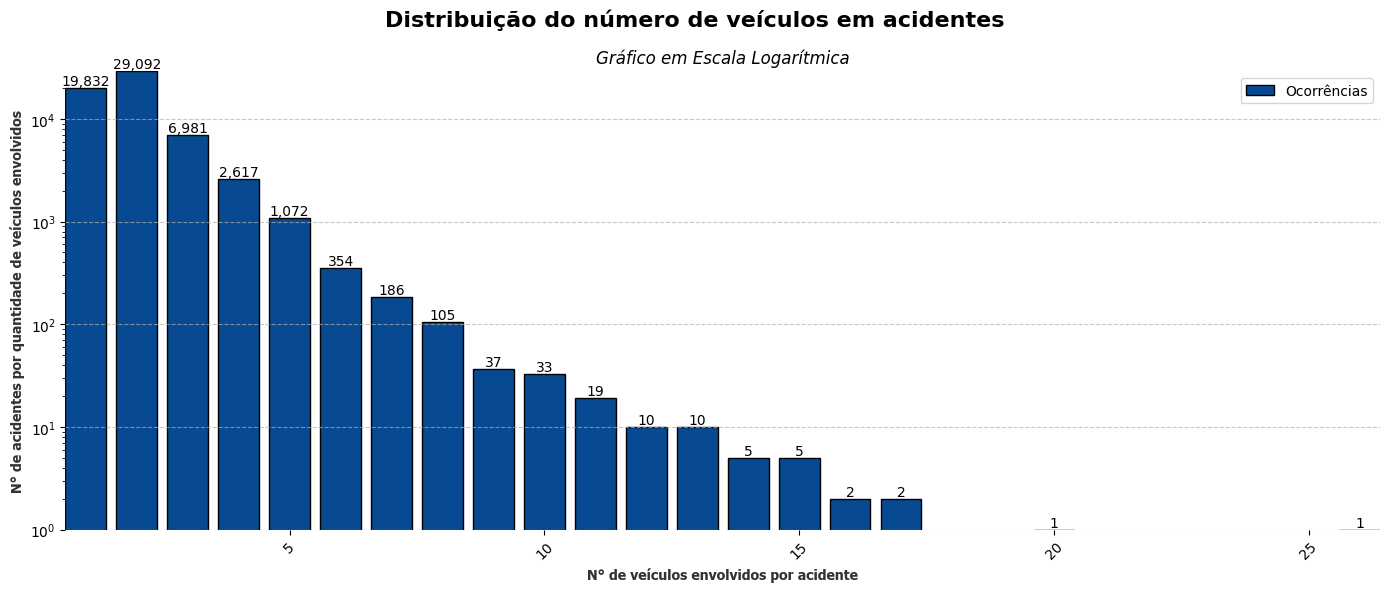

In [115]:
# GRÁFICO 3
# Agrupamento e ordenação
contagem = df_datatran['veiculos'].value_counts().sort_index()

# Plotagem
plt.figure(figsize=(14, 6))
bars = plt.bar(contagem.index, contagem.values, color=plt.cm.Blues_r(0.1), edgecolor='black', label='Ocorrências')

fontprops = {
    'color': 'k',
    'weight': 'semibold',
    'style': 'normal',
    'family': 'Tahoma',
    'alpha': 0.8
}

plt.suptitle('Distribuição do número de veículos em acidentes', fontsize=16, fontweight='semibold')
plt.title('Gráfico em Escala Logarítmica', fontsize=12, fontweight='regular', fontstyle='italic')
plt.xlabel('N° de veículos envolvidos por acidente', fontdict=fontprops)
plt.xticks(rotation=45, fontweight='medium')
plt.ylabel('N° de acidentes por quantidade de veículos envolvidos', fontdict=fontprops)
plt.yscale('log')
plt.box(False)
plt.grid(axis='y', linestyle='--', alpha=0.7)


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval,
             f'{int(yval):,}', ha='center', va='bottom', fontsize=10)


plt.legend(loc='upper right', frameon=True)

plt.tight_layout()
plt.margins(False)
plt.show()


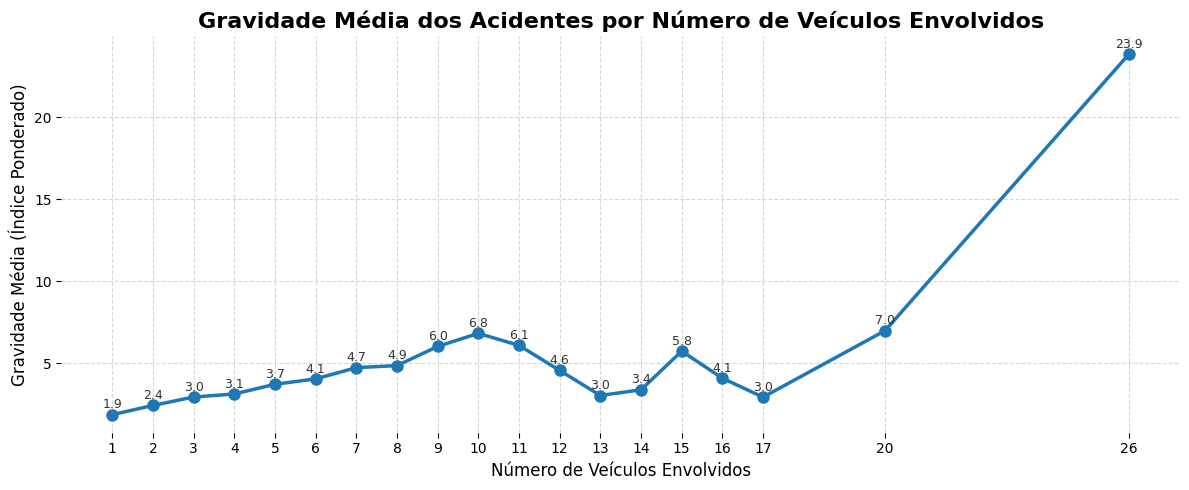

In [116]:
# GRÁFICO 2
# Agrupando por número de veículos e calculando a média do coeficiente de gravidade
gravidade_por_veiculo = df_datatran.groupby('veiculos')['gravidade_coeficiente'].mean().sort_index()

# Estilização do gráfico
plt.figure(figsize=(12, 5))
plt.plot(gravidade_por_veiculo.index, gravidade_por_veiculo.values, 
         marker='o', linestyle='-', color='#1f77b4', linewidth=2.5, markersize=8)

# Adicionando rótulos de valor nos pontos
for x, y in zip(gravidade_por_veiculo.index, gravidade_por_veiculo.values):
    plt.text(x, y + 0.2, f'{y:.1f}', ha='center', va='bottom', fontsize=9, color='#333')

# Títulos e rótulos
plt.title('Gravidade Média dos Acidentes por Número de Veículos Envolvidos',
          fontsize=16, weight='bold', loc='center')
plt.xlabel('Número de Veículos Envolvidos', fontsize=12)
plt.ylabel('Gravidade Média (Índice Ponderado)', fontsize=12)

# Grid e layout
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(gravidade_por_veiculo.index, fontsize=10)
plt.yticks(fontsize=10)
plt.box(False)
plt.tight_layout()

# Estilo geral
# plt.style.use('ggplot') 

plt.show()


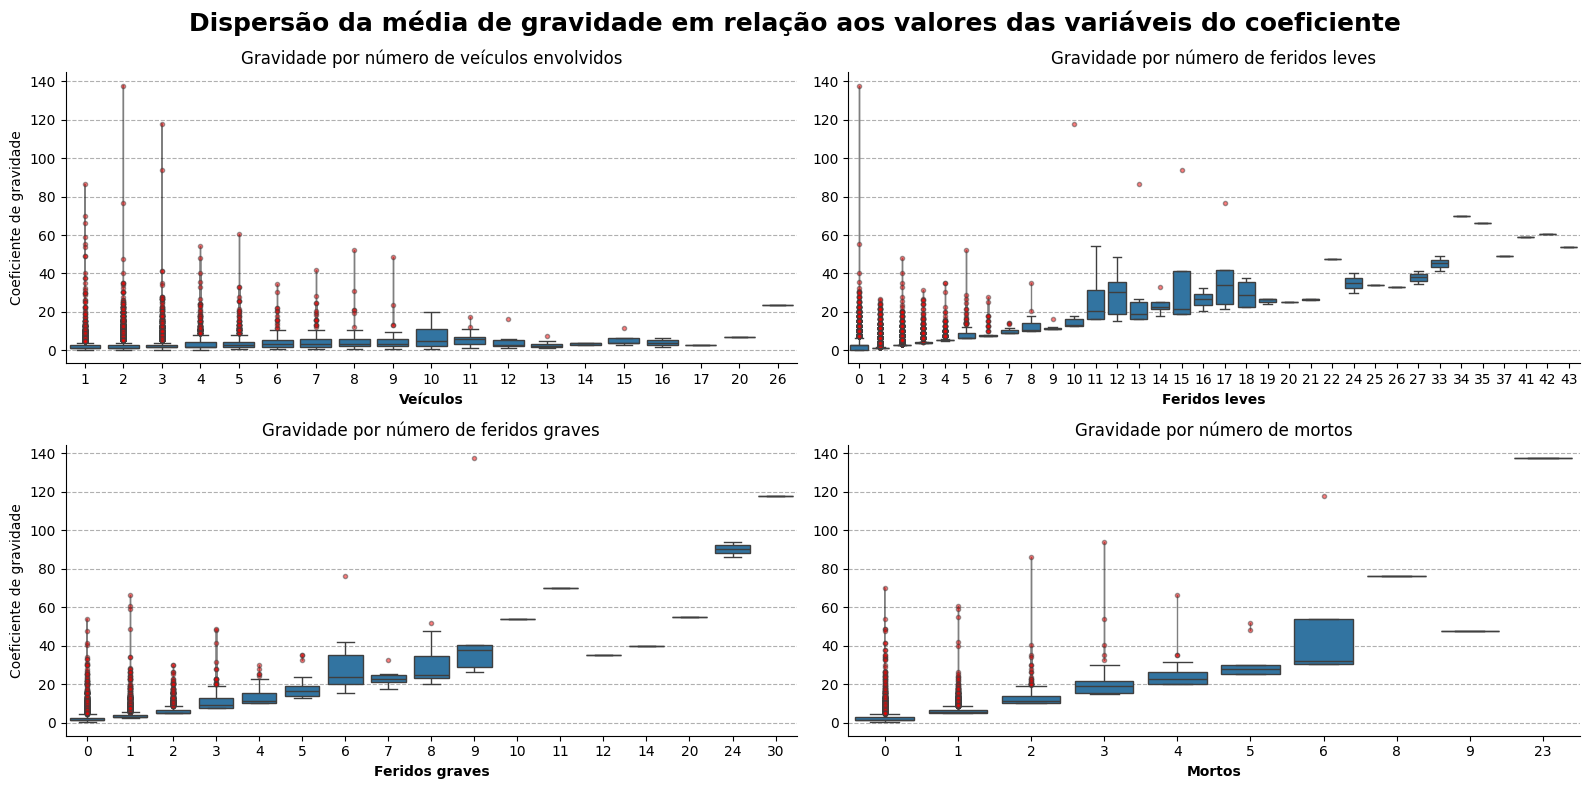

In [117]:
# GRÁFICO BOXPLOT

fig, axs = plt.subplots(2,2, figsize=(16,8))
fig.suptitle('Dispersão da média de gravidade em relação aos valores das variáveis do coeficiente', fontsize=18, fontweight='bold')

outlier_p = dict(
    marker='o',
    markersize=3,
    linestyle=None,
    markerfacecolor='red',
    alpha=0.5
)

#Gráfico1
sns.boxplot(x='veiculos', y='gravidade_coeficiente', data=df_datatran, ax=axs[0,0], flierprops=outlier_p)
axs[0,0].set_title('Gravidade por número de veículos envolvidos')
axs[0,0].set_ylabel('Coeficiente de gravidade')
axs[0,0].set_xlabel('Veículos', fontweight='semibold')
axs[0,0].grid(linestyle='--')
axs[0,0].xaxis.grid(False)
axs[0,0].spines[['top', 'right']].set_visible(False)

#Gráfico2
sns.boxplot(x='feridos_leves', y='gravidade_coeficiente', data=df_datatran, ax=axs[0,1], flierprops=outlier_p)
axs[0,1].set_title('Gravidade por número de feridos leves')
axs[0,1].set_ylabel(None)
axs[0,1].set_xlabel('Feridos leves', fontweight='semibold')
axs[0,1].grid(linestyle='--')
axs[0,1].xaxis.grid(False)
axs[0,1].spines[['top', 'right']].set_visible(False)

#Gráfico3
sns.boxplot(x='feridos_graves', y='gravidade_coeficiente', data=df_datatran, ax=axs[1,0], flierprops=outlier_p)
axs[1,0].set_title('Gravidade por número de feridos graves')
axs[1,0].set_ylabel('Coeficiente de gravidade')
axs[1,0].set_xlabel('Feridos graves', fontweight='semibold')
axs[1,0].grid(linestyle='--')
axs[1,0].xaxis.grid(False)
axs[1,0].spines[['top', 'right']].set_visible(False)

#Gráfico2
sns.boxplot(x='mortos', y='gravidade_coeficiente', data=df_datatran, ax=axs[1,1], flierprops=outlier_p)
axs[1,1].set_title('Gravidade por número de mortos')
axs[1,1].set_ylabel(None)
axs[1,1].set_xlabel('Mortos', fontweight='semibold')
axs[1,1].grid(linestyle='--')
axs[1,1].xaxis.grid(False)
axs[1,1].spines[['top', 'right']].set_visible(False)


plt.tight_layout()
plt.show()

---

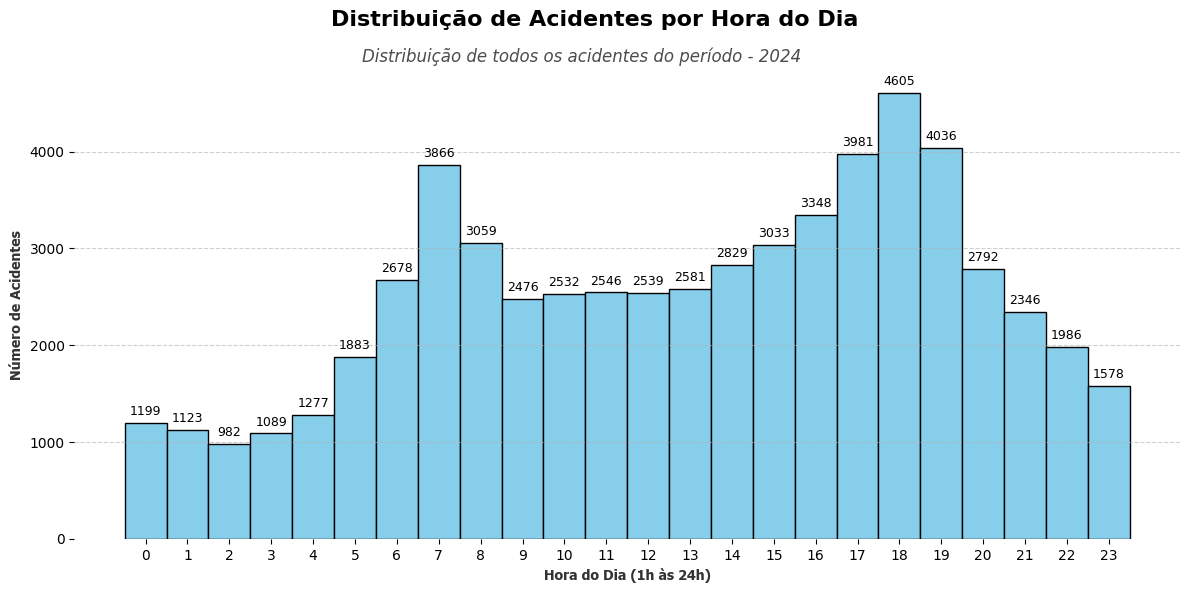

In [118]:
""" 
Explore como fatores como horário do acidente e o tipo de pista (simples ou dupla) influenciam os resultados.
"""

hora = df_datatran['horario'].apply(lambda x: x.hour)

fontprops = {
    'color': 'k',
    'weight': 'semibold',
    'style': 'normal',
    'family': 'Tahoma',
    'alpha': 0.8
}


plt.figure(figsize=(12,6))
contagens, bins, patches = plt.hist(hora, bins=range(0, 25), align='left', edgecolor='black', color='skyblue')

for bin_left, count in zip(bins[:-1], contagens):
    plt.text(bin_left, count + 50, int(count), ha='center', va='bottom', fontsize=9)

plt.suptitle('Distribuição de Acidentes por Hora do Dia', fontsize=16, fontweight='bold')
plt.title('Distribuição de todos os acidentes do período - 2024', fontsize=12, fontweight='regular', fontstyle='italic', x=0.459, alpha=0.7)
plt.xticks(range(0, 24))
plt.xlabel('Hora do Dia (1h às 24h)', fontdict=fontprops)
plt.ylabel('Número de Acidentes', fontdict=fontprops)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.box(None)
plt.show()


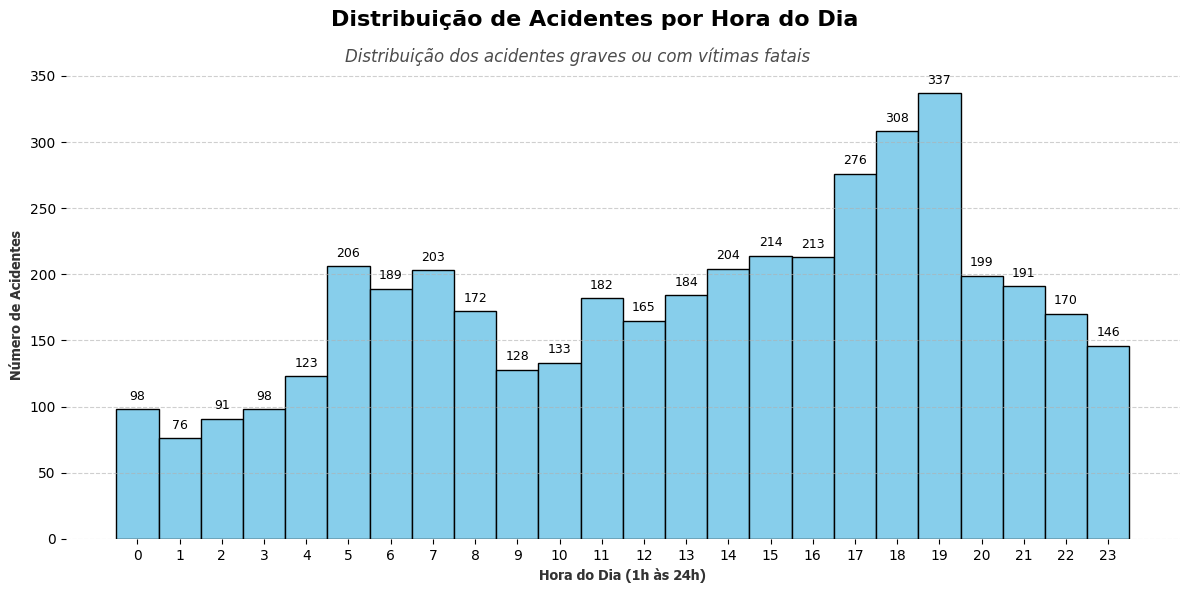

In [119]:
""" 
Explore como fatores como horário do acidente e o tipo de pista (simples ou dupla) influenciam os resultados.
"""
df_datatran_graves = df_datatran[(df_datatran['gravidade_nivel'] == 'alto') |
                                 (df_datatran['gravidade_nivel'] == 'muito alto')]
hora = df_datatran_graves['horario'].apply(lambda x: x.hour)

fontprops = {
    'color': 'k',
    'weight': 'semibold',
    'style': 'normal',
    'family': 'Tahoma',
    'alpha': 0.8
}


plt.figure(figsize=(12,6))
contagens, bins, patches = plt.hist(hora, bins=range(0, 25), align='left', edgecolor='black', color='skyblue')

for bin_left, count in zip(bins[:-1], contagens):
    plt.text(bin_left, count + 5, int(count), ha='center', va='bottom', fontsize=9)

plt.suptitle('Distribuição de Acidentes por Hora do Dia', fontsize=16, fontweight='bold')
plt.title('Distribuição dos acidentes graves ou com vítimas fatais', fontsize=12, fontweight='regular', fontstyle='italic', x=0.459, alpha=0.7)
plt.xticks(range(0, 24))
plt.xlabel('Hora do Dia (1h às 24h)', fontdict=fontprops)
plt.ylabel('Número de Acidentes', fontdict=fontprops)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.box(None)
plt.show()


<Figure size 1200x600 with 0 Axes>

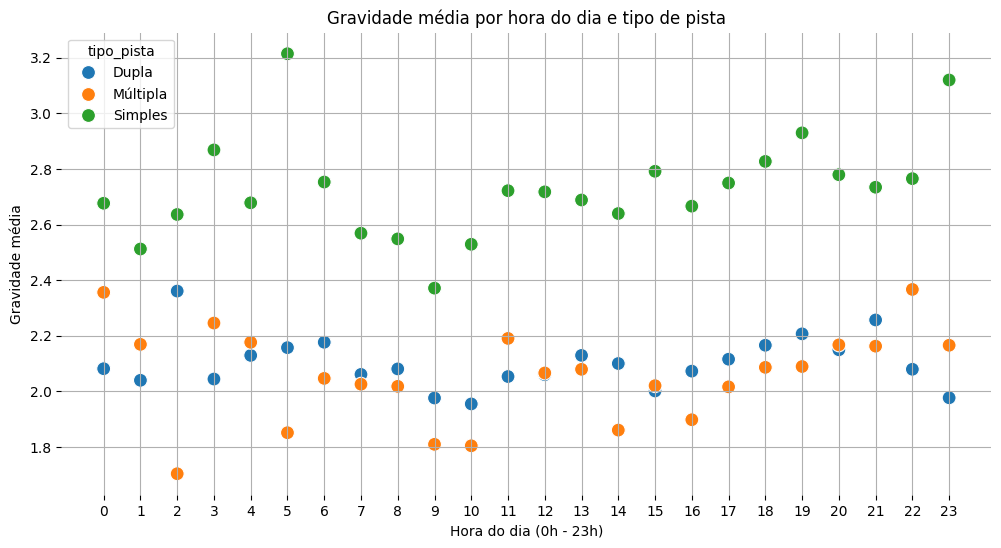

In [120]:
plt.figure(figsize=(12,6))

gravidade_por_pista_hora = df_datatran.groupby(['hora', 'tipo_pista'])['gravidade_coeficiente'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.scatterplot(
    data=gravidade_por_pista_hora,
    x='hora',
    y='gravidade_coeficiente',
    hue='tipo_pista',
    palette='tab10',
    s=100 
)

plt.title('Gravidade média por hora do dia e tipo de pista')
plt.xlabel('Hora do dia (0h - 23h)')
plt.ylabel('Gravidade média')
plt.xticks(range(0, 24))
plt.grid(True)
plt.box(None)
plt.show()

---

### Processamento de Linguagem Natural - PLN

In [121]:
"""Análise de Texto das Causas de Acidentes:
Agrupe causas semelhantes utilizando técnicas de análise textual.
Identifique as principais causas que contribuem para acidentes fatais e sugira intervenções específicas.
""" 

#modelo spacy
nlp_portugues = spacy.load("pt_core_news_md")

causas_fatais = df_datatran[df_datatran['mortos'] >= 1]
lista_causas = causas_fatais['causa_acidente'].dropna().str.strip().str.lower().unique().tolist()

#pré-processamento
def processar_spacy(causa):
    causa = re.sub(r'[^a-zà-ú0-9\s]', '', causa)
    doc = nlp_portugues(causa)
    lemas = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.is_space]
    return ' '.join(lemas)

causas_tratadas = [processar_spacy(causa) for causa in lista_causas]

#tf-idf
tfidf_vectorizer = TfidfVectorizer(max_features=300, norm='l1')
X_tfidf = tfidf_vectorizer.fit_transform(causas_tratadas)

cos_sim = cosine_similarity(X_tfidf)

# frequências das causas fatais
frequencias = Counter(causas_fatais['causa_acidente'].str.strip().str.lower())

# agrupamento
agrupados_spacy = {}
visitados = set()

for i, causa in enumerate(causas_tratadas):
    if i in visitados:
        continue
    grupo = [lista_causas[i]]
    visitados.add(i)
    for j in range(len(causas_tratadas)):
        if i != j and cos_sim[i, j] >= 0.10:
            grupo.append(lista_causas[j])
            visitados.add(j)
    causa_mais_frequente = max(grupo, key=lambda c: frequencias.get(c, 0))
    agrupados_spacy[causa_mais_frequente] = grupo


causa_para_grupo = {}
for grupo_causas in agrupados_spacy.values():
    mais_frequente = max(grupo_causas, key=lambda c: frequencias.get(c, 0))
    for causa in grupo_causas:
        causa_para_grupo[causa] = mais_frequente


#criar dataframe e adicionar nova coluna

df_datatran_nlp = pd.DataFrame(causas_fatais)
df_datatran_nlp = df_datatran_nlp[['id', 'causa_acidente', 'tipo_acidente', 'mortos']]
df_datatran_nlp['grupo_causa'] = (
    df_datatran_nlp['causa_acidente']
    .str.strip()
    .str.lower()
    .map(causa_para_grupo)
)

In [122]:
# Contar frequência de cada grupo entre os acidentes fatais
frequencia_grupos = (
    df_datatran_nlp['grupo_causa']
    .value_counts()
    .head(10)
    
)

# Exibir o nome do grupo e suas causas relacionadas
for grupo, freq in frequencia_grupos.items():
    print(f'\nGrupo: "{grupo}" ({freq} ocorrências fatais)')
    for causa, grupo_label in causa_para_grupo.items():
        if grupo_label == grupo:
            print(f' - {causa}')



Grupo: "ausência de reação do condutor" (578 ocorrências fatais)
 - ausência de sinalização
 - ausência de reação do condutor
 - sinalização mal posicionada

Grupo: "transitar na contramão" (551 ocorrências fatais)
 - transitar na contramão

Grupo: "pedestre andava na pista" (549 ocorrências fatais)
 - pedestre cruzava a pista fora da faixa
 - entrada inopinada do pedestre
 - pedestre andava na pista
 - pedestre - ingestão de álcool/ substâncias psicoativas

Grupo: "reação tardia ou ineficiente do condutor" (494 ocorrências fatais)
 - sistema de drenagem ineficiente
 - reação tardia ou ineficiente do condutor

Grupo: "acessar a via sem observar a presença dos outros veículos" (334 ocorrências fatais)
 - acessar a via sem observar a presença dos outros veículos
 - área urbana sem a presença de local apropriado para a travessia de pedestres

Grupo: "velocidade incompatível" (294 ocorrências fatais)
 - velocidade incompatível

Grupo: "ultrapassagem indevida" (244 ocorrências fatais)
 - u

In [123]:
#top 5 Gruposde causas fatais mais frequentes
top_5_grupos = frequencia_grupos.head(10)
print("\nTop 5 grupos de causas fatais mais frequentes:\n")
for i, (grupo, total) in enumerate(top_5_grupos.items(), start=1):
    print(f"{i}. Grupo: {grupo} — Ocorrências fatais: {total}")


Top 5 grupos de causas fatais mais frequentes:

1. Grupo: ausência de reação do condutor — Ocorrências fatais: 578
2. Grupo: transitar na contramão — Ocorrências fatais: 551
3. Grupo: pedestre andava na pista — Ocorrências fatais: 549
4. Grupo: reação tardia ou ineficiente do condutor — Ocorrências fatais: 494
5. Grupo: acessar a via sem observar a presença dos outros veículos — Ocorrências fatais: 334
6. Grupo: velocidade incompatível — Ocorrências fatais: 294
7. Grupo: ultrapassagem indevida — Ocorrências fatais: 244
8. Grupo: manobra de mudança de faixa — Ocorrências fatais: 168
9. Grupo: condutor deixou de manter distância do veículo da frente — Ocorrências fatais: 118
10. Grupo: suicídio (presumido) — Ocorrências fatais: 73


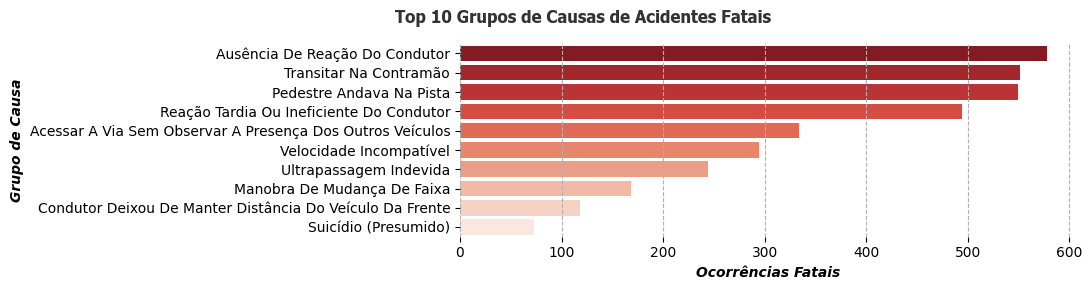

In [124]:
# Gráfico
plt.figure(figsize=(11, 3))
sns.barplot(
    x=top_5_grupos.values,
    y=[grupo.title() for grupo in top_5_grupos.index],
    palette='Reds_r'
)
plt.xlabel("Ocorrências Fatais", fontweight='semibold', fontstyle='italic')
plt.ylabel("Grupo de Causa", fontweight='semibold', fontstyle='italic')
plt.title("Top 10 Grupos de Causas de Acidentes Fatais", fontdict=fontprops, x=0.2, pad=15)
plt.grid(axis='x', linestyle='--')
plt.tight_layout()
plt.box(None)
plt.show()